# DrivAerNet++ Pressure Field prediction: 


## Preprocess data: 

In [ ]:
import os
import glob
import numpy as np
import pyvista as pv
from tqdm import tqdm

In [ ]:
def load_vtk_surface_pyvista(vtk_path, pressure_key="p"):
    """
    Load surface points and pressure using PyVista.
    """
    mesh = pv.read(vtk_path)

    points = mesh.points.astype(np.float32)      # (N, 3)
    pressure = mesh.point_data[pressure_key].astype(np.float32)  # (N,)

    return points, pressure

def normalize_points(points):
    centroid = np.mean(points, axis=0)
    points = points - centroid

    scale = np.max(np.linalg.norm(points, axis=1))
    points = points / (scale + 1e-9)

    return points, centroid, scale

def farthest_point_sample_numpy(points, n_samples):
    N = points.shape[0]
    centroids = np.zeros((n_samples,), dtype=np.int64)
    distances = np.ones((N,), dtype=np.float32) * 1e10
    farthest = np.random.randint(0, N)

    for i in range(n_samples):
        centroids[i] = farthest
        centroid = points[farthest]
        dist = np.sum((points - centroid) ** 2, axis=1)
        mask = dist < distances
        distances[mask] = dist[mask]
        farthest = np.argmax(distances)

    return centroids


def vtk_to_npz_pyvista(
    vtk_path,
    out_path,
    num_points=4096,
    pressure_key="p",
    normalize=True,
):
    # Load
    points, pressure = load_vtk_surface_pyvista(vtk_path, pressure_key)

    # Normalize
    if normalize:
        points, centroid, scale = normalize_points(points)
    else:
        centroid = np.zeros(3, dtype=np.float32)
        scale = 1.0

    # FPS
    fps_idx = farthest_point_sample_numpy(points, num_points)
    points = points[fps_idx]
    pressure = pressure[fps_idx]

    # Save
    np.savez_compressed(
        out_path,
        points=points,
        pressure=pressure,
        centroid=centroid,
        scale=scale,
    )

def process_vtk_folder_pyvista(
    vtk_folder,
    output_folder,
    num_points=4096,
    pressure_key="p",
    normalize=True,
):
    os.makedirs(output_folder, exist_ok=True)

    vtk_files = sorted(glob.glob(os.path.join(vtk_folder, "*.vtk")))
    print(f"Found {len(vtk_files)} VTK files")

    for vtk_path in tqdm(vtk_files):
        name = os.path.splitext(os.path.basename(vtk_path))[0]
        out_path = os.path.join(output_folder, f"{name}.npz")

        if os.path.exists(out_path):
            continue

        try:
            vtk_to_npz_pyvista(
                vtk_path,
                out_path,
                num_points=num_points,
                pressure_key=pressure_key,
                normalize=normalize,
            )
        except Exception as e:
            print(f"[ERROR] {name}: {e}")

VTK_FOLDER = "02_dataset/car_pressure_field/F_D_WM_WW_1"
OUTPUT_FOLDER = "02_dataset/car_pc_vtk"

NUM_POINTS = 4096
PRESSURE_KEY = "p"
NORMALIZE_GEOMETRY = True

In [ ]:
process_vtk_folder_pyvista(
    vtk_folder=VTK_FOLDER,
    output_folder=OUTPUT_FOLDER,
    num_points=NUM_POINTS,
    pressure_key=PRESSURE_KEY,
    normalize=NORMALIZE_GEOMETRY,
)

## RegDGCNN Model

### Dataset class:

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import glob
import os

In [3]:
class CarPressureDataset(Dataset):
    def __init__(self, npz_folder, denormalize=False):
        """
        Args:
            npz_folder (str): Folder containing .npz point cloud files
            denormalize (bool): Restore original geometry using centroid/scale
        """
        self.files = sorted(glob.glob(os.path.join(npz_folder, "*.npz")))
        if len(self.files) == 0:
            raise ValueError(f"No .npz files found in folder: {npz_folder}")
        self.denormalize = denormalize

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        npz_path = self.files[idx]
        data = np.load(npz_path)

        pts = data['points']           # (num_points, 3)
        pressure = data['pressure']    # (num_points,)

        # Denormalize if requested
        if self.denormalize and 'centroid' in data and 'scale' in data:
            pts = pts * data['scale'] + data['centroid']

        # Convert to PyTorch tensors
        pts = torch.tensor(pts, dtype=torch.float32).transpose(0, 1)  # (3, num_points)
        pressure = torch.tensor(pressure, dtype=torch.float32)        # (num_points,)

        return pts, pressure


In [6]:
def create_dataloaders(npz_folder, batch_size=4, denormalize=False,
                       val_ratio=0.08, test_ratio=0.08, num_workers=2):
    """
    Create DataLoaders for training, validation, and testing.
    """
    # Load full dataset
    full_dataset = CarPressureDataset(npz_folder, denormalize=denormalize)

    total_len = len(full_dataset)

    # Ensure at least 1 sample in each split
    val_len = max(int(total_len * val_ratio), 1)
    test_len = max(int(total_len * test_ratio), 1)
    train_len = total_len - val_len - test_len
    if train_len <= 0:
        raise ValueError("Not enough samples for the requested train/val/test split. Reduce val_ratio/test_ratio.")

    train_set, val_set, test_set = random_split(full_dataset, [train_len, val_len, test_len])

    # DataLoaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

In [7]:
if __name__ == "__main__":
    NPZ_FOLDER = "02_dataset/car_pc_vtk"   # <-- change to your folder
    BATCH_SIZE = 4

    train_loader, val_loader, test_loader = create_dataloaders(NPZ_FOLDER, batch_size=BATCH_SIZE)

    print("Dataset split sizes:")
    print(f"  Train: {len(train_loader.dataset)}")
    print(f"  Val  : {len(val_loader.dataset)}")
    print(f"  Test : {len(test_loader.dataset)}\n")

    # Check shapes for one batch
    coords, pressure = next(iter(train_loader))
    print("Sanity check - shapes of one batch:")
    print(f"  Coordinates: {coords.shape}")  # (batch_size, 3, num_points)
    print(f"  Pressure   : {pressure.shape}") # (batch_size, num_points)

Dataset split sizes:
  Train: 418
  Val  : 39
  Test : 39

Sanity check - shapes of one batch:
  Coordinates: torch.Size([4, 3, 4096])
  Pressure   : torch.Size([4, 4096])


### Model Architecture: 

In [8]:
# model_pressure.py
"""
Model architecture for pressure field prediction on the DrivAerNet++ dataset.

This module implements the RegDGCNN model for predicting pressure fields
on 3D car models from the DrivAerNet++ dataset.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np


def knn(x, k):
    """
    k-nearest neighbors algorithm.

    Args:
        x: Input tensor of shape (batch_size, feature_dim, num_points)
        k: Number of neighbors to consider

    Returns:
        Indices of k-nearest neighbors for each point
    """
    inner = -2 * torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x ** 2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)

    idx = pairwise_distance.topk(k=k, dim=-1)[1]  # (batch_size, num_points, k)
    return idx


def get_graph_feature(x, k=20, idx=None, dim9=False):
    """
    Construct edge features for graph convolution.

    Args:
        x: Input tensor of shape (batch_size, feature_dim, num_points)
        k: Number of neighbors to use for graph construction
        idx: Optional pre-computed nearest neighbor indices
        dim9: Whether to use additional dimensional features

    Returns:
        Edge features for graph convolution
    """
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        idx = knn(x, k=k)  # (batch_size, num_points, k)

    device = x.device
    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1) * num_points
    idx = idx + idx_base
    idx = idx.view(-1)

    _, num_dims, _ = x.size()
    x = x.transpose(2, 1).contiguous()  # (batch_size, num_points, num_dims)
    feature = x.view(batch_size * num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims)
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)

    feature = torch.cat((feature - x, x), dim=3).permute(0, 3, 1, 2).contiguous()
    return feature  # (batch_size, 2*num_dims, num_points, k)


class Transform_Net(nn.Module):
    def __init__(self, args):
        super(Transform_Net, self).__init__()
        self.args = args
        self.k = 3

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv1d(128, 1024, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(negative_slope=0.2))

        self.linear1 = nn.Linear(1024, 512, bias=False)
        self.bn3 = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, 256, bias=False)
        self.bn4 = nn.BatchNorm1d(256)

        self.transform = nn.Linear(256, 3*3)
        init.constant_(self.transform.weight, 0)
        init.eye_(self.transform.bias.view(3, 3))

    def forward(self, x):
        batch_size = x.size(0)

        x = self.conv1(x)                       # (batch_size, 3*2, num_points, k) -> (batch_size, 64, num_points, k)
        x = self.conv2(x)                       # (batch_size, 64, num_points, k) -> (batch_size, 128, num_points, k)
        x = x.max(dim=-1, keepdim=False)[0]     # (batch_size, 128, num_points, k) -> (batch_size, 128, num_points)

        x = self.conv3(x)                       # (batch_size, 128, num_points) -> (batch_size, 1024, num_points)
        x = x.max(dim=-1, keepdim=False)[0]     # (batch_size, 1024, num_points) -> (batch_size, 1024)

        x = F.leaky_relu(self.bn3(self.linear1(x)), negative_slope=0.2)     # (batch_size, 1024) -> (batch_size, 512)
        x = F.leaky_relu(self.bn4(self.linear2(x)), negative_slope=0.2)     # (batch_size, 512) -> (batch_size, 256)

        x = self.transform(x)                   # (batch_size, 256) -> (batch_size, 3*3)
        x = x.view(batch_size, 3, 3)            # (batch_size, 3*3) -> (batch_size, 3, 3)

        return x

class RegDGCNN_pressure(nn.Module):
    def __init__(self, args):
        super(RegDGCNN_pressure, self).__init__()
        self.args = args
        self.seg_num_all = 1
        self.k = args['k']
        self.transform_net = Transform_Net(args)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(64)
        self.bn6 = nn.BatchNorm1d(args['emb_dims'])
        self.bn7 = nn.BatchNorm1d(64)
        self.bn8 = nn.BatchNorm1d(256)
        self.bn9 = nn.BatchNorm1d(256)
        self.bn10 = nn.BatchNorm1d(128)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64 * 2, 64, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn4,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv2d(64 * 2, 64, kernel_size=1, bias=False),
                                   self.bn5,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv6 = nn.Sequential(nn.Conv1d(192, args['emb_dims'], kernel_size=1, bias=False),
                                   self.bn6,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv7 = nn.Sequential(nn.Conv1d(16, 64, kernel_size=1, bias=False),
                                   self.bn7,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv8 = nn.Sequential(nn.Conv1d(1216, 256, kernel_size=1, bias=False),
                                   self.bn8,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.dp1 = nn.Dropout(p=args['dropout'])
        self.conv9 = nn.Sequential(nn.Conv1d(256, 256, kernel_size=1, bias=False),
                                   self.bn9,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.dp2 = nn.Dropout(p=args['dropout'])
        self.conv10 = nn.Sequential(nn.Conv1d(256, 128, kernel_size=1, bias=False),
                                    self.bn10,
                                    nn.LeakyReLU(negative_slope=0.2))
        self.conv11 = nn.Conv1d(128, self.seg_num_all, kernel_size=1, bias=False)

    def forward(self, x):
        batch_size = x.size(0)
        num_points = x.size(2)

        # x0 = get_graph_feature(x, k=self.k)  # (batch_size, 3, num_points) -> (batch_size, 3*2, num_points, k)
        # t = self.transform_net(x0)  # (batch_size, 3, 3)
        # x = x.transpose(2, 1)  # (batch_size, 3, num_points) -> (batch_size, num_points, 3)
        # x = torch.bmm(x, t)  # (batch_size, num_points, 3) * (batch_size, 3, 3) -> (batch_size, num_points, 3)
        # x = x.transpose(2, 1)  # (batch_size, num_points, 3) -> (batch_size, 3, num_points)

        x = get_graph_feature(x, k=self.k)  # (batch_size, 3, num_points) -> (batch_size, 3*2, num_points, k)
        x = self.conv1(x)  # (batch_size, 3*2, num_points, k) -> (batch_size, 64, num_points, k)
        x = self.conv2(x)  # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points, k)
        x1 = x.max(dim=-1, keepdim=False)[0]  # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = get_graph_feature(x1, k=self.k)  # (batch_size, 64, num_points) -> (batch_size, 64*2, num_points, k)
        x = self.conv3(x)  # (batch_size, 64*2, num_points, k) -> (batch_size, 64, num_points, k)
        x = self.conv4(x)  # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points, k)
        x2 = x.max(dim=-1, keepdim=False)[0]  # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = get_graph_feature(x2, k=self.k)  # (batch_size, 64, num_points) -> (batch_size, 64*2, num_points, k)
        x = self.conv5(x)  # (batch_size, 64*2, num_points, k) -> (batch_size, 64, num_points, k)
        x3 = x.max(dim=-1, keepdim=False)[0]  # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = torch.cat((x1, x2, x3), dim=1)  # (batch_size, 64*3, num_points)

        x = self.conv6(x)  # (batch_size, 64*3, num_points) -> (batch_size, emb_dims, num_points)
        x = x.max(dim=-1, keepdim=True)[0]  # (batch_size, emb_dims, num_points) -> (batch_size, emb_dims, 1)

        # l = l.view(batch_size, -1, 1)  # (batch_size, num_categoties, 1)
        # l = self.conv7(l)  # (batch_size, num_categoties, 1) -> (batch_size, 64, 1)
        #
        # x = torch.cat((x, l), dim=1)  # (batch_size, 1088, 1)
        x = x.repeat(1, 1, num_points)  # (batch_size, 1088, num_points)

        x = torch.cat((x, x1, x2, x3), dim=1)  # (batch_size, 1024+64*3, num_points)

        x = self.conv8(x)  # (batch_size, 1024+64*3, num_points) -> (batch_size, 256, num_points)
        x = self.dp1(x)
        x = self.conv9(x)  # (batch_size, 256, num_points) -> (batch_size, 256, num_points)
        x = self.dp2(x)
        x = self.conv10(x)  # (batch_size, 256, num_points) -> (batch_size, 128, num_points)
        x = self.conv11(x)  # (batch_size, 256, num_points) -> (batch_size, seg_num_all, num_points)

        return x


In [16]:
import torch


# --- Dummy args ---
args = {
    'k': 20,          # number of neighbors
    'emb_dims': 1024, # embedding dims in conv6
    'dropout': 0.5
}

# --- Initialize model ---
model = RegDGCNN_pressure(args)

# --- Dummy input ---
batch_size = 2
num_points = 4096
x = torch.rand(batch_size, 3, num_points)  # (B, 3, N)

# --- Forward pass ---
output = model(x)

print("Input shape :", x.shape)         # (2, 3, 4096)
print("Output shape:", output.shape)    # (2, 1, 4096)
print("Output stats: min {:.4f}, max {:.4f}, mean {:.4f}".format(
    output.min().item(), output.max().item(), output.mean().item()
))


Input shape : torch.Size([2, 3, 4096])
Output shape: torch.Size([2, 1, 4096])
Output stats: min -1.5623, max 1.7533, mean -0.0925


### Training Module

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import logging
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [18]:
# ===============================
# Hyperparameters
# ===============================
args = {
    'k': 30,
    'emb_dims': 1024,
    'dropout': 0.4
}

BATCH_SIZE = 12
LEARNING_RATE = 1e-3
NUM_EPOCHS = 1000
CHECKPOINT_DIR = "./checkpoints"
LOG_DIR = "./logs"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)


In [20]:
# ===============================
# Logging Setup
# ===============================
log_file = os.path.join(LOG_DIR, "training.log")

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(message)s",
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)


In [21]:
# ===============================
# Model, Loss, Optimizer
# ===============================
model = RegDGCNN_pressure(args).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# ===============================
# Train & Validation Functions
# ===============================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0

    for points, pressure in loader:
        points = points.to(device)
        pressure = pressure.to(device)

        optimizer.zero_grad()
        output = model(points).squeeze(1)
        loss = criterion(output, pressure)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * points.size(0)

    return running_loss / len(loader.dataset)


def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for points, pressure in loader:
            points = points.to(device)
            pressure = pressure.to(device)
            output = model(points).squeeze(1)
            loss = criterion(output, pressure)
            running_loss += loss.item() * points.size(0)

    return running_loss / len(loader.dataset)

# ===============================
# Resume from Checkpoint (if exists)
# ===============================
start_epoch = 1
best_val_loss = float('inf')
latest_ckpt = os.path.join(CHECKPOINT_DIR, "latest.pth")

if os.path.exists(latest_ckpt):
    checkpoint = torch.load(latest_ckpt, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_loss = checkpoint["best_val_loss"]

    logging.info(f"Resumed training from epoch {checkpoint['epoch']}")

# ===============================
# Training Loop
# ===============================
for epoch in range(start_epoch, NUM_EPOCHS + 1):

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)

    logging.info(
        f"Epoch [{epoch}/{NUM_EPOCHS}] | "
        f"Train Loss: {train_loss:.6f} | "
        f"Val Loss: {val_loss:.6f}"
    )

    # -------------------------------
    # Save Latest Checkpoint (always)
    # -------------------------------
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_val_loss": best_val_loss
    }, latest_ckpt)

    # -------------------------------
    # Save Best Model
    # -------------------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")

        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss
        }, best_path)

        logging.info(f"Saved BEST model at epoch {epoch}")

    # -------------------------------
    # Save Epoch Checkpoint every 50
    # -------------------------------
    if epoch % 50 == 0:
        epoch_ckpt = os.path.join(CHECKPOINT_DIR, f"epoch_{epoch}.pth")
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss
        }, epoch_ckpt)

        logging.info(f"Saved checkpoint: epoch_{epoch}.pth")

2026-01-06 11:36:41,382 | Epoch [1/1000] | Train Loss: 20311.726516 | Val Loss: 14519.232973
2026-01-06 11:36:41,455 | Saved BEST model at epoch 1
2026-01-06 11:36:46,212 | Epoch [2/1000] | Train Loss: 17226.439612 | Val Loss: 24591.563001
2026-01-06 11:36:51,033 | Epoch [3/1000] | Train Loss: 13699.885943 | Val Loss: 16680.834034
2026-01-06 11:36:55,792 | Epoch [4/1000] | Train Loss: 10234.614473 | Val Loss: 4099.903671
2026-01-06 11:36:55,873 | Saved BEST model at epoch 4
2026-01-06 11:37:00,639 | Epoch [5/1000] | Train Loss: 7304.275367 | Val Loss: 3182.961388
2026-01-06 11:37:00,714 | Saved BEST model at epoch 5
2026-01-06 11:37:05,468 | Epoch [6/1000] | Train Loss: 5188.570534 | Val Loss: 3252.717661
2026-01-06 11:37:10,281 | Epoch [7/1000] | Train Loss: 3719.844157 | Val Loss: 3846.292850
2026-01-06 11:37:15,058 | Epoch [8/1000] | Train Loss: 2869.478660 | Val Loss: 5706.360990
2026-01-06 11:37:19,877 | Epoch [9/1000] | Train Loss: 2343.639049 | Val Loss: 8917.341046
2026-01-06 1

### Inference

In [23]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# ===============================
# Device
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===============================
# Paths
# ===============================
CHECKPOINT_PATH = "./checkpoints/best_model.pth"
SAVE_DIR = "./inference_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# ===============================
# Model
# ===============================
args = {
    'k': 30,
    'emb_dims': 1024,
    'dropout': 0.4
}

model = RegDGCNN_pressure(args).to(device)
model.eval()

# Load trained weights
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

print(f"Loaded model from epoch {checkpoint['epoch']}")

# ===============================
# Inference
# ===============================
def run_inference(model, loader):
    all_points = []
    all_gt = []
    all_pred = []

    with torch.no_grad():
        for points, pressure in tqdm(loader, desc="Running Inference"):
            points = points.to(device)        # (B, 3, N)
            pressure = pressure.to(device)    # (B, N)

            preds = model(points).squeeze(1)  # (B, N)

            all_points.append(points.cpu().numpy())
            all_gt.append(pressure.cpu().numpy())
            all_pred.append(preds.cpu().numpy())

    all_points = np.concatenate(all_points, axis=0)
    all_gt = np.concatenate(all_gt, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)

    return all_points, all_gt, all_pred


Using device: cuda
Loaded model from epoch 763


In [24]:
def plot_gt_vs_pred_2d(points, gt, pred, sample_idx=0, plane="xy"):
    """
    points: (B, 3, N)
    gt, pred: (B, N)
    """

    pts = points[sample_idx].transpose(1, 0)  # (N, 3)
    gt_p = gt[sample_idx]
    pred_p = pred[sample_idx]

    if plane == "xy":
        x, y = pts[:, 0], pts[:, 1]
    elif plane == "xz":
        x, y = pts[:, 0], pts[:, 2]
    elif plane == "yz":
        x, y = pts[:, 1], pts[:, 2]
    else:
        raise ValueError("Invalid plane")

    vmin = min(gt_p.min(), pred_p.min())
    vmax = max(gt_p.max(), pred_p.max())

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    sc1 = axs[0].scatter(x, y, c=gt_p, s=3, cmap="jet", vmin=vmin, vmax=vmax)
    axs[0].set_title("Ground Truth Pressure")
    axs[0].set_aspect("equal")
    axs[0].axis("off")

    sc2 = axs[1].scatter(x, y, c=pred_p, s=3, cmap="jet", vmin=vmin, vmax=vmax)
    axs[1].set_title("Predicted Pressure")
    axs[1].set_aspect("equal")
    axs[1].axis("off")

    fig.colorbar(sc1, ax=axs, fraction=0.046)
    plt.tight_layout()
    plt.show()


In [25]:
def parity_plot(gt, pred, num_points=20000):
    gt_flat = gt.reshape(-1)
    pred_flat = pred.reshape(-1)

    # Subsample for clarity
    idx = np.random.choice(len(gt_flat), min(num_points, len(gt_flat)), replace=False)

    plt.figure(figsize=(6, 6))
    plt.scatter(gt_flat[idx], pred_flat[idx], s=2, alpha=0.5)
    min_v = min(gt_flat.min(), pred_flat.min())
    max_v = max(gt_flat.max(), pred_flat.max())
    plt.plot([min_v, max_v], [min_v, max_v], 'r--')

    plt.xlabel("Ground Truth Pressure")
    plt.ylabel("Predicted Pressure")
    plt.title("GT vs Predicted Pressure")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Running Inference: 100%|██████████| 10/10 [00:00<00:00, 26.48it/s]
/tmp/ipykernel_120058/522551789.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


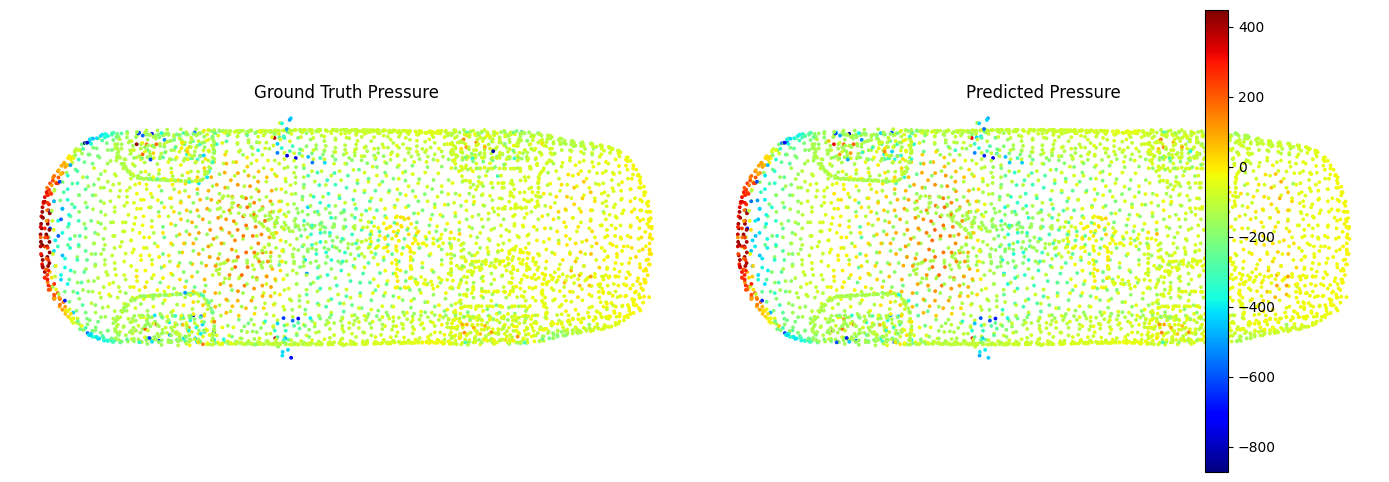

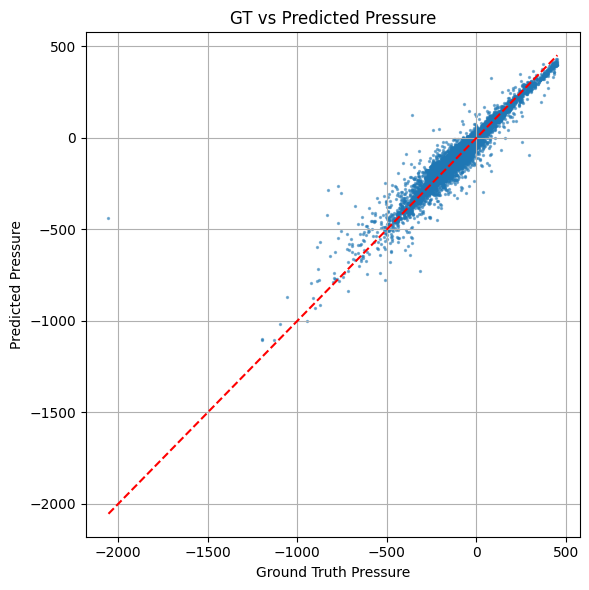

In [26]:
# Run inference
points, gt, pred = run_inference(model, test_loader)

# Side-by-side visualization
plot_gt_vs_pred_2d(points, gt, pred, sample_idx=0, plane="xy")

# Parity plot
parity_plot(gt, pred)
